In [51]:
# the libraries used for the project

from __future__ import print_function
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.gridspec as gridspec
from torchvision.utils import save_image
import torchvision

In [52]:
# in order to reach reproductibility we set a random seed 
manualSeed = 999
# uncomment just if new results are wanted
#manualSeed = random.randint(1, 10000) 
random.seed(manualSeed)
torch.manual_seed(manualSeed)

In [53]:
# the path to the root folder for the Icons50 dataset
dataroot = 'C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/Icons-50/'

# the batch size defines the number of training examples that are propagated through the network
# DCGAN paper recommends 128
batch_size = 128

# Spatial size of training images. All images will be resized to this size using a transformer.
icon_size = 64

# number of channels in the training images. the images are RGB which means it has 3 channels.
nc = 3

# the size of the random variable z which it should be 100 as specified in DCGAN paper
nz = 100

# learning rate for the Adam optimisers 
lr = 0.0002

# the momentum term beta1 for the Adam optimiser
beta1 = 0.5

# the number of gpu's available
ngpu = 1

# Number of workers for dataloader
workers = 2

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

In [54]:
def plotIcons(dataloader, classes, imageNo = 8):
    
    '''

    The function plots a sample of images from the dataloader along with the class labels. 

    It takes as inputs the following: 

    - the dataloader to load the dataset
    - the classes which are array type objects containing the class labels in the same order as in the dataset
    - the number of images that should not exceed the batch size
    - model - only if a model is provided

    '''
    
    # It gets the images and their true labels
    images, labels = next(iter(dataloader))

    plt.figure(figsize=(16,16))#this plots an image 
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(images.to(device)[:imageNo], padding=1, normalize=True).cpu(),(1,2,0)))
    
    # print true labels
    print('True labels: ', '     '.join('%5s' % classes[labels[j]] for j in range(imageNo)))


def getIndex(dataset):
    
    '''
    
    The function getIndex() returns a dictionary of classes. The value of each class is a dictionary containing the 
    indices and the datapoints. The input taken is the dataset which should be ImageFolder class - a generic data 
    loader where the images are structured as follows:


    /Icons-50/Icons-50/airplane/apple_0_airplane.png
    /Icons-50/Icons-50/boat/apple_0_canoe.png
    
    
    The output is a nested dictionary with the class name as the key (the folder's name) and a dictionary containing 
    the indices representing the images in order and the length of the class  as values. An example of the dictionary
    format would be as follows:

    
    dictionary = { 'airplane':{
                   'indices': [1,2,3,4,5],
                   'length': 5
                 },
                   'book':{
                   'indices': [6,7,8],
                   'length': 3
                 },

                 ...

                   'writing_utensils':{
                   'indices': [9997,9998,9999,10000],
                   'length': 4
                 }}


    '''
    targets = torch.tensor([t[1] for t in dataset.samples])
    dictionary = {}
    
    for x,y in dataset.class_to_idx.items():
        dictionary[x] = {'indices': (targets == y).nonzero().reshape(-1)}
        dictionary[x]['length'] = len(dictionary[x]['indices'])
        
    return dictionary


def plot_batch(dataloader):    
    
     # plot images from the dataloader 
        
    real_batch = next(iter(dataloader))
    plt.figure(figsize=(8,8))
    plt.axis("off")
    plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))

The class airplane has 76 entries.
The class arrow_directions has 392 entries.
The class ball has 192 entries.
The class biking has 100 entries.
The class bird has 229 entries.
The class blade has 90 entries.
The class boat has 289 entries.
The class books has 208 entries.
The class building has 312 entries.
The class bunny_ears has 160 entries.
The class cartwheeling has 105 entries.
The class clock has 417 entries.
The class cloud has 141 entries.
The class disk has 63 entries.
The class drinks has 238 entries.
The class emotion_face has 429 entries.
The class envelope has 119 entries.
The class family has 455 entries.
The class fast_train has 158 entries.
The class feline has 363 entries.
The class flag has 446 entries.
The class flower has 197 entries.
The class footwear has 126 entries.
The class golfing has 98 entries.
The class hand has 429 entries.
The class hat has 108 entries.
The class heart has 396 entries.
The class holding_hands has 187 entries.
The class japanese_ideogra

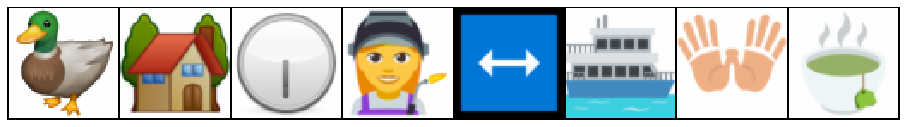

In [55]:
# here I create the dataset and transform the images
dataset = dset.ImageFolder(root=dataroot,
                           transform=transforms.Compose([
                           transforms.Resize(icon_size),
                           transforms.CenterCrop(icon_size),
                           transforms.RandomHorizontalFlip(p=0.5),
                           transforms.ToTensor(),
                           transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ]))

getDictionary = getIndex(dataset)
for a,b in getDictionary.items():
    print(f"The class {a} has {b['length']} entries.")

dataloader = torch.utils.data.DataLoader(dataset, batch_size = batch_size, shuffle = True)

plotIcons(dataloader, dataset.classes, imageNo = 8)

In [56]:
# Weights Init has the purpose of preventing the layer activation outputs from dissappearing 
# during the forward pass process.

def weights_init(m):
   
    classname = m.__class__.__name__
    
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
        
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [57]:
# Generator Code

class Generator(nn.Module):
    
    def __init__(self, n_classes, ngpu, ngf = 64):
        
        '''
        The generator class for images with dimensions 64 x 64 x 3.
        
        The input parameters declared are: 

        n_classes - which is the number of classes found in the dataset 
        
        ngpu - which is the number of GPUs that are going to be used in the training process

        ngf - representing the size of feature maps that are propagated through the generator network

        '''
        
        super(Generator, self).__init__()
        
        self.ngpu = ngpu
        
        self.n_classes = n_classes
        
        self.label_emb = nn.Embedding(n_classes, n_classes)
        
        self.main = nn.Sequential(
            
            # the input is projected from 100x1 noise plus the number of classes into 1024x4x4. 
            # This is known as projecting and shaping 
            nn.ConvTranspose2d(nz + n_classes, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            
            # 1024x4x4
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            
            # 512x8x8
            # the Generator is using a transposed convolutional layer (upsampling) along 
            # with Batch Normalisation and ReLU activation to produce an image from the random noise.
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            
            # 256x16x16
            # Generator is using the previous layers to produce an image. It is going through
            # transposed convolutional layer along with Batch Normalisation and ReLU activation until it
            # reaches the dimensionality of the output space of 3x64x64 as seen below
            nn.ConvTranspose2d(ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            
            # 128x32x32
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # 3x64x64
        )

    def forward(self, input, labels):
    
        # Concatenate label embedding and noise to produce input and then reshape the flattened layer
        flat_embed_input = torch.cat((self.label_emb(labels), input), -1)

        reshaped_input = flat_embed_input.view((-1,nz + self.n_classes,1,1)) 
        
        gen_img = self.main(reshaped_input)
        
        return gen_img

In [58]:
class Discriminator(nn.Module):
    
    def __init__(self, n_classes, ngpu, ndf = 64):
        
        '''
        
        The implementation of the D model is similar to the G model. The order of the layers has been flipped 
        and the ConvTranspose2d is replaced with a Conv2d layer. It is also divided into two separate functions - init() and forward().

        
        In the initialiser the same input parameters are declared and the Sequential class has been divided into 
        convolution layers and linear layers.

        The forward function is running the input through the convolutional layers and it flattens the output 
        from the main layer. Later, it creates the label layer and concatenates the attened output to the label layer. 

        Therefore, the last step is to run the attened output and the merged layer through the linear layers.


        '''
        
        super(Discriminator, self).__init__()
        
        self.ngpu = ngpu
        
        self.label_embedding = nn.Embedding(n_classes, n_classes)
        
        self.convolution_layers = nn.Sequential(
            # 3x64x64
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 128x32x32
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 256x16x16
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 512x8x8
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            
            # 1024x4x4
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
        )
        
        self.linear_layers = nn.Sequential(
            
            nn.Linear(in_features = 1 + n_classes, # flattened output and embedding
                      out_features = 512), 
            
            nn.LeakyReLU(0.2, inplace=True) ,
        
            nn.Linear(in_features = 512, 
                      out_features = 1), # this can be true or false
            
            nn.Sigmoid()
        )
        

    def forward(self, input, labels):
        
        x = self.convolution_layers(input) 
       
        x = x.view(x.size(0), -1) 
        
        y = self.label_embedding(labels) 
        
        x = torch.cat((x, y), -1) 
        
        x = self.linear_layers(x) 
        
        return x

In [59]:
class cDCGAN(object):
    
    def _checkDirectory(self, dirName):
        
        if not os.path.exists(dirName):
            print(f"{dirName} directory does not exist and we are making {dirName}")
            os.makedirs(dirName)
            
        else: print(f"{dirName} directory exists.")
    
    
    def __init__(self, dataloader, classes, save_dir, num_epochs,
                 criterion, netD, netG, optimizerD, optimizerG, device):
        
        # The model parameters
        self.num_epochs = num_epochs 
        self.start_epoch = 1 
        self.criterion = criterion # loss function
        self.real_label = 1 
        self.fake_label = 0
        
        # The saving locations
        self._checkDirectory(save_dir) 
        self.checkpoint_dir = os.path.join(save_dir, 'checkpoints')
        self._checkDirectory(self.checkpoint_dir) 
        self.fake_image_dir = os.path.join(save_dir, 'fake_images')
        self._checkDirectory(self.fake_image_dir) 
        
        # The data parameters
        self.dataloader = dataloader
        self.classes = classes # the class labels
        self.n_classes = len(classes) # the number of classes

        # The networks initialisation
        self.netD = netD
        self.netG = netG
        self.optimizerD = optimizerD
        self.optimizerG = optimizerG
        
        # Specify the decive used
        self.device = device
        
        #  Fixed noise to see the progression of the generator
        self.fixed_noise = torch.randn(64, nz, device=self.device) 
            
        
    def genFake(self, class_index_tensor, noise, image_name = 'random', save = True):
        
        # function that generates a batch of fake images using the current generator weights.

        with torch.no_grad():
    
            fake = self.netG(noise, class_index_tensor).detach().cpu()
        
        if save: 
            save_image(fake.data, f'{self.fake_image_dir}/{image_name}.png',
                       nrow=8, padding=2, normalize=True)
        
        return fake.data
    

    def train(self):
        
        # THE TRAIN LOOP 

        if self.num_epochs == 0:
            print(f"No epochs set for training. Exit.")
            return
            
        self.G_losses = [] # generator loss
        self.D_losses = [] # discriminator loss
        iters = 0

        print("The training loop is starting now...")

        for epoch in range(self.start_epoch, self.start_epoch + self.num_epochs):

            for i, (imgs, classLabels) in enumerate(self.dataloader):

                ##############################################################################
                # Updating the D network is maximising the log(D(x)) + log(1 - D(G(z))) which means
                # maximising the probability of correctly classifying the image given as real or fake

                ## Train with all-real batch
               
                self.netD.zero_grad()

                realImages = imgs.to(self.device)
                b_size = realImages.size(0)

                validity_label = torch.full((b_size,), self.real_label, device=device)

                # forward pass it through D
                output = self.netD(realImages, classLabels).view(-1)

                # calculate loss function log(D(x)) on all real batch
                errD_real = self.criterion(output, validity_label)

                # calculate gradients for D in backward pass
                errD_real.backward()
                D_x = output.mean().item()


                ###########################
                ## Train with all-fake batch
                

                noise = torch.randn(b_size, nz, device=device) # torch.Size([128, 10])

                gen_labels = torch.randint(self.n_classes, (b_size,)).type(torch.LongTensor) # torch.Size([128, 3])

                fake = self.netG(noise, gen_labels)

                validity_label.fill_(self.fake_label)

                # classify all fake batch with D
                output = self.netD(fake.detach(), gen_labels).view(-1)

                # calculate loss function on the all-fake batch
                errD_fake = self.criterion(output, validity_label)

                # calculate the gradients for this batch
                errD_fake.backward()
                D_G_z1 = output.mean().item()

                errD = errD_real + errD_fake

                # update D
                self.optimizerD.step()


                ############################
                # Updating the G network is maximising the log(D(G(z))) which means to generate reasonablelooking fake images. T

                self.netG.zero_grad()
                # setting the fake labels as real for the generator cost
                validity_label.fill_(self.real_label)  

                # performing another forward pass of all fake batch through D
                output = self.netD(fake, gen_labels).view(-1)
                
                # calculate loss function of G
                errG = self.criterion(output, validity_label)
                
                # calculate gradients for G
                errG.backward()
                D_G_z2 = output.mean().item()
                
                # Update G
                self.optimizerG.step()

                # the training stats generated every epoch
                if i % 50 == 0:
                    print(f'[{epoch}/{self.start_epoch + self.num_epochs - 1}][{i}/{len(self.dataloader)}]\tLoss_D: {round(errD.item(),2)}\tLoss_G: {round(errG.item(),2)}\tD(x): {round(D_x,2)}\tD(G(z)): {round(D_G_z1/D_G_z2,2)}')

                # Save Losses 
                self.G_losses.append(errG.item())
                self.D_losses.append(errD.item())

                # Check how the generator is doing by saving G's output on fixed_noise
                # every 500 iterations, or on the last batch of the last epoch
                if (iters % 500 == 0) or ((epoch == self.num_epochs-1) and (i == len(self.dataloader)-1)):
                    
                    print("Saving a batch of fake images now...")
                    
                    class_index = torch.arange(self.n_classes) # get class indices
                    for i in class_index:
                        class_index_tensor = torch.LongTensor(64).fill_(i) # repeat the same class index 10 times
                        self.genFake(class_index_tensor, self.fixed_noise,
                                                  image_name = f'{self.classes[i]}_e{epoch}', save = True)

                iters += 1

            # Save model every 50 epochs
            if epoch == 1 or epoch % 50 == 0: self.save(epoch)

        print(f"Finished Training for {epoch} epochs.")
        self.save(epoch)

        
    def load(self, loadpath):
        '''
        When loading model checkpoint, just load the epoch and state dicts to continue training.
        The D-loss and G-loss can be stored within their respective checkpoints
        and referred to later when needed.
        '''
        if os.path.isfile(loadpath):
            print(f"=> loading checkpoint: {loadpath}")
            checkpoint = torch.load(loadpath)

            self.start_epoch = checkpoint['epoch'] + 1
            self.netD.load_state_dict(checkpoint['netD_state_dict'])
            self.netG.load_state_dict(checkpoint['netG_state_dict'])
            self.optimizerD.load_state_dict(checkpoint['optimizerD'])
            self.optimizerG.load_state_dict(checkpoint['optimizerG'])

            print(f"=> loaded checkpoint: {loadpath}")
            print(f"Last epoch was {checkpoint['epoch']}")

        else: 
            print(f"=> No checkpoint found at: {loadpath}")
                  

    def save(self, epoch):
        
        # save the model checkpoint
        filepath = f'{self.checkpoint_dir}/checkpoint_e{epoch}.pth.tar'
        print(f"=> Saving checkpoint: {filepath}")

        state = {
            'D_losses': self.D_losses,
            'G_losses': self.G_losses,
            'epoch': epoch,
            'netD_state_dict': self.netD.state_dict(),
            'optimizerD': self.optimizerD.state_dict(),
            'netG_state_dict': self.netG.state_dict(),
            'optimizerG': self.optimizerG.state_dict(),
        }

        torch.save(state, filepath) 

In [60]:
netD = Discriminator(len(dataset.classes), ngpu).to(device)

# Applying the weights init
netD.apply(weights_init)

print(netD)

# Creating the generator
netG = Generator(len(dataset.classes), ngpu).to(device)

# Applying the weights init
netG.apply(weights_init)

print(netG)

Discriminator(
  (label_embedding): Embedding(50, 50)
  (convolution_layers): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
  )

In [61]:
kwargs = {
    'dataloader': dataloader,
    'classes': dataset.classes,
    'save_dir':'C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/',
    'num_epochs': 1000,
    'criterion': nn.BCELoss(), # Initialize BCELoss function
    'netD': netD,
    'netG': netG,
    'optimizerD': optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999)),
    'optimizerG': optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999)),
    'device': device,
}
    
icon_gen = cDCGAN(**kwargs)

C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/ directory exists.
C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/checkpoints directory exists.
C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/fake_images directory exists.


In [62]:
icon_gen.load('C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/checkpoints/checkpoint_e500.pth.tar')

=> loading checkpoint: C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/checkpoints/checkpoint_e500.pth.tar
=> loaded checkpoint: C:/Users/liviu/Desktop/Dissertation-Final/Project/Icons50/results/checkpoints/checkpoint_e500.pth.tar
Last epoch was 500


In [ ]:
# I trained it on Google Colab and on a different laptop as well 

In [12]:
icon_gen.train()

Starting Training Loop...
[1/500][0/79]	Loss_D: 1.4	Loss_G: 0.78	D(x): 0.47	D(G(z)): 1.02
Saving a batch of fake images.
[1/500][50/79]	Loss_D: 0.42	Loss_G: 3.87	D(x): 0.75	D(G(z)): 4.24
=> Saving checkpoint: /home/andreighr/icons50/Icons-50/results/checkpoints/checkpoint_e1.pth.tar
[2/500][0/79]	Loss_D: 0.17	Loss_G: 3.83	D(x): 0.95	D(G(z)): 2.82
[2/500][50/79]	Loss_D: 0.37	Loss_G: 2.96	D(x): 0.8	D(G(z)): 1.55
[3/500][0/79]	Loss_D: 1.84	Loss_G: 8.24	D(x): 0.97	D(G(z)): 502.86
[3/500][50/79]	Loss_D: 0.35	Loss_G: 4.31	D(x): 0.91	D(G(z)): 10.17
[4/500][0/79]	Loss_D: 0.77	Loss_G: 4.96	D(x): 0.8	D(G(z)): 37.38
[4/500][50/79]	Loss_D: 1.17	Loss_G: 4.42	D(x): 0.9	D(G(z)): 35.51
[5/500][0/79]	Loss_D: 0.96	Loss_G: 4.92	D(x): 0.87	D(G(z)): 45.89
[5/500][50/79]	Loss_D: 0.41	Loss_G: 1.78	D(x): 0.84	D(G(z)): 0.82
[6/500][0/79]	Loss_D: 0.75	Loss_G: 2.32	D(x): 0.6	D(G(z)): 0.89
[6/500][50/79]	Loss_D: 0.85	Loss_G: 4.58	D(x): 0.96	D(G(z)): 29.08
[7/500][0/79]	Loss_D: 0.68	Loss_G: 2.3	D(x): 0.71	D(G(z)):

[58/500][50/79]	Loss_D: 0.33	Loss_G: 3.58	D(x): 0.97	D(G(z)): 3.88
[59/500][0/79]	Loss_D: 0.71	Loss_G: 6.85	D(x): 0.98	D(G(z)): 101.68
[59/500][50/79]	Loss_D: 0.37	Loss_G: 3.67	D(x): 0.94	D(G(z)): 7.04
[60/500][0/79]	Loss_D: 5.22	Loss_G: 9.27	D(x): 1.0	D(G(z)): 940.32
[60/500][50/79]	Loss_D: 0.3	Loss_G: 4.42	D(x): 0.95	D(G(z)): 6.43
[61/500][0/79]	Loss_D: 0.29	Loss_G: 4.09	D(x): 0.96	D(G(z)): 5.86
[61/500][50/79]	Loss_D: 0.29	Loss_G: 4.03	D(x): 0.96	D(G(z)): 7.01
[62/500][0/79]	Loss_D: 1.21	Loss_G: 7.02	D(x): 0.99	D(G(z)): 292.72
[62/500][50/79]	Loss_D: 0.19	Loss_G: 4.46	D(x): 0.9	D(G(z)): 1.19
[63/500][0/79]	Loss_D: 0.62	Loss_G: 3.76	D(x): 0.76	D(G(z)): 0.61
[63/500][50/79]	Loss_D: 1.56	Loss_G: 9.91	D(x): 0.99	D(G(z)): 2803.63
[64/500][0/79]	Loss_D: 1.02	Loss_G: 5.29	D(x): 0.96	D(G(z)): 39.97
Saving a batch of fake images.
[64/500][50/79]	Loss_D: 0.27	Loss_G: 3.13	D(x): 0.85	D(G(z)): 0.59
[65/500][0/79]	Loss_D: 0.51	Loss_G: 6.2	D(x): 0.97	D(G(z)): 95.89
[65/500][50/79]	Loss_D: 0.21	Lo

[116/500][50/79]	Loss_D: 0.32	Loss_G: 5.79	D(x): 0.96	D(G(z)): 26.89
[117/500][0/79]	Loss_D: 2.37	Loss_G: 9.17	D(x): 0.98	D(G(z)): 1249.6
[117/500][50/79]	Loss_D: 0.14	Loss_G: 4.57	D(x): 0.99	D(G(z)): 8.51
[118/500][0/79]	Loss_D: 0.27	Loss_G: 4.93	D(x): 0.96	D(G(z)): 16.33
[118/500][50/79]	Loss_D: 0.2	Loss_G: 5.15	D(x): 0.99	D(G(z)): 16.88
[119/500][0/79]	Loss_D: 0.12	Loss_G: 4.59	D(x): 0.97	D(G(z)): 3.61
[119/500][50/79]	Loss_D: 0.75	Loss_G: 7.83	D(x): 1.0	D(G(z)): 291.99
[120/500][0/79]	Loss_D: 0.17	Loss_G: 3.71	D(x): 0.9	D(G(z)): 0.46
[120/500][50/79]	Loss_D: 0.08	Loss_G: 5.36	D(x): 0.96	D(G(z)): 0.69
[121/500][0/79]	Loss_D: 0.09	Loss_G: 4.31	D(x): 0.94	D(G(z)): 1.03
Saving a batch of fake images.
[121/500][50/79]	Loss_D: 0.16	Loss_G: 3.44	D(x): 0.95	D(G(z)): 1.9
[122/500][0/79]	Loss_D: 0.08	Loss_G: 3.69	D(x): 0.97	D(G(z)): 1.33
[122/500][50/79]	Loss_D: 0.05	Loss_G: 4.14	D(x): 0.99	D(G(z)): 1.99
[123/500][0/79]	Loss_D: 0.24	Loss_G: 4.69	D(x): 0.99	D(G(z)): 7.65
[123/500][50/79]	Loss

[174/500][0/79]	Loss_D: 0.16	Loss_G: 6.0	D(x): 0.91	D(G(z)): 0.8
[174/500][50/79]	Loss_D: 0.05	Loss_G: 4.74	D(x): 1.0	D(G(z)): 4.47
[175/500][0/79]	Loss_D: 0.08	Loss_G: 5.17	D(x): 0.99	D(G(z)): 3.92
[175/500][50/79]	Loss_D: 0.1	Loss_G: 5.61	D(x): 0.96	D(G(z)): 1.43
=> Saving checkpoint: /home/andreighr/icons50/Icons-50/results/checkpoints/checkpoint_e175.pth.tar
[176/500][0/79]	Loss_D: 0.64	Loss_G: 7.47	D(x): 0.99	D(G(z)): 174.31
[176/500][50/79]	Loss_D: 1.27	Loss_G: 1.85	D(x): 0.56	D(G(z)): 0.0
[177/500][0/79]	Loss_D: 0.26	Loss_G: 3.62	D(x): 0.9	D(G(z)): 2.5
[177/500][50/79]	Loss_D: 0.1	Loss_G: 2.87	D(x): 0.98	D(G(z)): 0.84
[178/500][0/79]	Loss_D: 6.9	Loss_G: 12.02	D(x): 1.0	D(G(z)): 9521.29
Saving a batch of fake images.
[178/500][50/79]	Loss_D: 0.19	Loss_G: 2.64	D(x): 0.9	D(G(z)): 0.45
[179/500][0/79]	Loss_D: 0.13	Loss_G: 3.77	D(x): 1.0	D(G(z)): 3.19
[179/500][50/79]	Loss_D: 0.41	Loss_G: 6.1	D(x): 0.99	D(G(z)): 64.72
[180/500][0/79]	Loss_D: 0.05	Loss_G: 5.91	D(x): 0.98	D(G(z)): 0.89

[230/500][50/79]	Loss_D: 0.43	Loss_G: 6.72	D(x): 0.79	D(G(z)): 0.41
[231/500][0/79]	Loss_D: 0.02	Loss_G: 6.41	D(x): 1.0	D(G(z)): 1.97
[231/500][50/79]	Loss_D: 0.03	Loss_G: 4.5	D(x): 0.99	D(G(z)): 0.91
[232/500][0/79]	Loss_D: 0.04	Loss_G: 5.07	D(x): 1.0	D(G(z)): 1.5
[232/500][50/79]	Loss_D: 0.03	Loss_G: 6.54	D(x): 1.0	D(G(z)): 3.14
[233/500][0/79]	Loss_D: 0.71	Loss_G: 10.52	D(x): 0.78	D(G(z)): 3.82
[233/500][50/79]	Loss_D: 0.08	Loss_G: 4.43	D(x): 0.96	D(G(z)): 0.92
[234/500][0/79]	Loss_D: 0.65	Loss_G: 8.95	D(x): 1.0	D(G(z)): 1257.41
[234/500][50/79]	Loss_D: 0.05	Loss_G: 5.28	D(x): 0.97	D(G(z)): 0.96
[235/500][0/79]	Loss_D: 0.05	Loss_G: 4.45	D(x): 1.0	D(G(z)): 1.9
Saving a batch of fake images.
[235/500][50/79]	Loss_D: 0.19	Loss_G: 6.44	D(x): 1.0	D(G(z)): 7.71
[236/500][0/79]	Loss_D: 0.02	Loss_G: 5.99	D(x): 1.0	D(G(z)): 3.81
[236/500][50/79]	Loss_D: 0.05	Loss_G: 6.71	D(x): 1.0	D(G(z)): 3.59
[237/500][0/79]	Loss_D: 0.04	Loss_G: 4.81	D(x): 0.98	D(G(z)): 0.97
[237/500][50/79]	Loss_D: 0.02	L

[288/500][0/79]	Loss_D: 0.1	Loss_G: 4.97	D(x): 0.97	D(G(z)): 2.27
[288/500][50/79]	Loss_D: 0.02	Loss_G: 5.45	D(x): 0.99	D(G(z)): 1.36
[289/500][0/79]	Loss_D: 0.1	Loss_G: 4.9	D(x): 0.99	D(G(z)): 2.48
[289/500][50/79]	Loss_D: 0.46	Loss_G: 1.14	D(x): 0.77	D(G(z)): 0.04
[290/500][0/79]	Loss_D: 0.04	Loss_G: 4.66	D(x): 0.99	D(G(z)): 1.29
[290/500][50/79]	Loss_D: 0.03	Loss_G: 4.63	D(x): 0.99	D(G(z)): 1.3
[291/500][0/79]	Loss_D: 0.1	Loss_G: 4.58	D(x): 0.93	D(G(z)): 0.28
[291/500][50/79]	Loss_D: 0.02	Loss_G: 5.55	D(x): 1.0	D(G(z)): 1.89
[292/500][0/79]	Loss_D: 18.74	Loss_G: 7.8	D(x): 1.0	D(G(z)): 3.65
Saving a batch of fake images.
[292/500][50/79]	Loss_D: 0.04	Loss_G: 5.5	D(x): 0.97	D(G(z)): 0.68
[293/500][0/79]	Loss_D: 0.02	Loss_G: 4.87	D(x): 0.99	D(G(z)): 1.14
[293/500][50/79]	Loss_D: 0.1	Loss_G: 5.22	D(x): 0.98	D(G(z)): 8.0
[294/500][0/79]	Loss_D: 0.01	Loss_G: 5.79	D(x): 1.0	D(G(z)): 1.1
[294/500][50/79]	Loss_D: 0.04	Loss_G: 4.61	D(x): 1.0	D(G(z)): 3.52
[295/500][0/79]	Loss_D: 0.01	Loss_G: 

[345/500][50/79]	Loss_D: 0.01	Loss_G: 5.24	D(x): 1.0	D(G(z)): 1.34
[346/500][0/79]	Loss_D: 0.02	Loss_G: 5.09	D(x): 0.99	D(G(z)): 1.1
[346/500][50/79]	Loss_D: 0.01	Loss_G: 5.16	D(x): 1.0	D(G(z)): 1.06
[347/500][0/79]	Loss_D: 0.02	Loss_G: 5.27	D(x): 1.0	D(G(z)): 1.43
[347/500][50/79]	Loss_D: 0.01	Loss_G: 5.68	D(x): 1.0	D(G(z)): 1.28
[348/500][0/79]	Loss_D: 0.45	Loss_G: 7.27	D(x): 1.0	D(G(z)): 215.19
[348/500][50/79]	Loss_D: 0.07	Loss_G: 3.79	D(x): 0.97	D(G(z)): 0.82
[349/500][0/79]	Loss_D: 0.05	Loss_G: 5.35	D(x): 1.0	D(G(z)): 4.2
Saving a batch of fake images.
[349/500][50/79]	Loss_D: 0.01	Loss_G: 6.42	D(x): 1.0	D(G(z)): 1.08
[350/500][0/79]	Loss_D: 0.1	Loss_G: 5.99	D(x): 0.95	D(G(z)): 0.44
[350/500][50/79]	Loss_D: 0.04	Loss_G: 4.76	D(x): 0.99	D(G(z)): 1.92
=> Saving checkpoint: /home/andreighr/icons50/Icons-50/results/checkpoints/checkpoint_e350.pth.tar
[351/500][0/79]	Loss_D: 0.01	Loss_G: 6.39	D(x): 0.99	D(G(z)): 0.94
[351/500][50/79]	Loss_D: 0.03	Loss_G: 5.96	D(x): 0.98	D(G(z)): 0.96


[402/500][50/79]	Loss_D: 0.02	Loss_G: 5.15	D(x): 0.99	D(G(z)): 1.35
[403/500][0/79]	Loss_D: 0.99	Loss_G: 11.28	D(x): 1.0	D(G(z)): 11477.92
[403/500][50/79]	Loss_D: 0.01	Loss_G: 4.74	D(x): 1.0	D(G(z)): 1.22
[404/500][0/79]	Loss_D: 0.02	Loss_G: 4.87	D(x): 1.0	D(G(z)): 0.81
[404/500][50/79]	Loss_D: 0.03	Loss_G: 5.01	D(x): 0.98	D(G(z)): 0.84
[405/500][0/79]	Loss_D: 0.01	Loss_G: 6.71	D(x): 0.99	D(G(z)): 1.06
[405/500][50/79]	Loss_D: 0.04	Loss_G: 4.85	D(x): 1.0	D(G(z)): 3.76
[406/500][0/79]	Loss_D: 16.19	Loss_G: 10.06	D(x): 1.0	D(G(z)): 4.07
Saving a batch of fake images.
[406/500][50/79]	Loss_D: 0.27	Loss_G: 7.08	D(x): 0.84	D(G(z)): 1.35
[407/500][0/79]	Loss_D: 0.16	Loss_G: 2.77	D(x): 0.9	D(G(z)): 0.11
[407/500][50/79]	Loss_D: 0.13	Loss_G: 2.09	D(x): 0.93	D(G(z)): 0.12
[408/500][0/79]	Loss_D: 0.1	Loss_G: 4.05	D(x): 0.97	D(G(z)): 0.7
[408/500][50/79]	Loss_D: 0.04	Loss_G: 4.22	D(x): 0.99	D(G(z)): 1.29
[409/500][0/79]	Loss_D: 0.07	Loss_G: 4.19	D(x): 0.96	D(G(z)): 0.59
[409/500][50/79]	Loss_D: 

[460/500][0/79]	Loss_D: 0.27	Loss_G: 4.99	D(x): 1.0	D(G(z)): 11.1
[460/500][50/79]	Loss_D: 0.02	Loss_G: 4.95	D(x): 1.0	D(G(z)): 1.41
[461/500][0/79]	Loss_D: 0.01	Loss_G: 5.53	D(x): 0.99	D(G(z)): 0.97
[461/500][50/79]	Loss_D: 0.02	Loss_G: 4.91	D(x): 1.0	D(G(z)): 1.97
[462/500][0/79]	Loss_D: 0.02	Loss_G: 6.36	D(x): 0.98	D(G(z)): 1.16
[462/500][50/79]	Loss_D: 0.01	Loss_G: 5.17	D(x): 1.0	D(G(z)): 1.49
[463/500][0/79]	Loss_D: 0.05	Loss_G: 7.15	D(x): 0.98	D(G(z)): 2.35
Saving a batch of fake images.
[463/500][50/79]	Loss_D: 0.05	Loss_G: 5.44	D(x): 1.0	D(G(z)): 6.09
[464/500][0/79]	Loss_D: 0.56	Loss_G: 9.48	D(x): 1.0	D(G(z)): 587.73
[464/500][50/79]	Loss_D: 0.04	Loss_G: 9.04	D(x): 0.97	D(G(z)): 0.73
[465/500][0/79]	Loss_D: 0.01	Loss_G: 6.08	D(x): 1.0	D(G(z)): 1.09
[465/500][50/79]	Loss_D: 0.01	Loss_G: 6.62	D(x): 0.99	D(G(z)): 1.41
[466/500][0/79]	Loss_D: 0.01	Loss_G: 5.28	D(x): 1.0	D(G(z)): 0.48
[466/500][50/79]	Loss_D: 0.01	Loss_G: 5.61	D(x): 1.0	D(G(z)): 1.16
[467/500][0/79]	Loss_D: 0.02	Lo